In [26]:
import os
import sys
import itertools

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

if '..' not in sys.path: sys.path.insert(0, '..')
from common import colors

In [27]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array([
    [0, 9],
    [1, 6],
    [2, 5],
    [3, 20],
    [4, 10],
    [5, 20],
    [6, 30],
    [7, 42],
    [8, 24],
    [9, 32],
    [10, 45],

])
order = 3

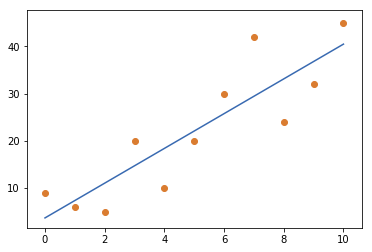

In [28]:
m = len(data)
X = np.array([np.ones(m), data[:, 0]]).T
y = np.array(data[:, 1]).reshape(-1, 1)
betaHat = np.linalg.solve(X.T.dot(X), X.T.dot(y))
plt.figure(1)
xx = np.linspace(0, 10, 5)
yy = np.array(betaHat[0] + betaHat[1] * xx)
plt.plot(xx, yy.T, color=colors.line_indexed[0])
plt.scatter(data[:, 0], data[:, 1], color=colors.line_indexed[1])
plt.show()


In [50]:
class ParametricCurve(object):
    def __call__(self, u):
        raise NotImplementedError("Subclasses must implement this")
        
# B-Spline Basis function
def N(i, k, x, knots):
    T = knots
    if k == 0:
        if T[i] <= x < T[i+1]:
            return 1.0
        else:
            return 0.0
    else:
        part1 = 0.0
        if (T[i+k] - T[i] != 0.0):
            part1 = ((x-T[i])/(T[i+k] - T[i])) * N(i, k-1, x, T)
        part2 = 0.0
        if (T[i+k+1] - T[i+1] != 0.0):
            part2 = ((T[i+k+1] - x)/(T[i+k+1] - T[i+1])) * N(i+1, k-1, x, T)
        return part1 + part2
      
class BSplineCurve(ParametricCurve):
    def __init__(self, order, knots, points):
        self.order = order
        self.p = self.order - 1
        self.knots = knots
        m = len(self.knots) - 1
        self.points = points
        n = len(self.points) - 1
        assert len(self.points) > self.order, "Number of points: {} must be > than order: {}".format(len(self.points), self.order)
        assert self.p == m - n - 1, "p == m - n - 1 ... {} == {} - {} - 1".format(self.p, m, n)
        self.knot_range = (self.knots[-1] - self.knots[0])

        
    def __call__(self, u):
        assert u >= 0.0 and u <= 1.0
        t = (u * self.knot_range) + self.knots[0]
        final = 0.0
        for i, Pi in enumerate(self.points):
            basis = N(i, self.p, t, self.knots)
            final += basis * Pi
        return final
    
def uniform_knots(n, order):
    knots = list(range(n-order+2))
    beginning = [0] * (order-1)
    ending = [knots[-1]] * (order-1)
    return beginning + knots + ending

In [51]:
def b_spline_A(order, cp_size, data_size):
    assert(order <= cp_size)
    m = data_size
    n = cp_size
    knots = uniform_knots(n, order)
    print(knots)
    knot_range = ((knots[-1]-0.01) - (knots[0]+0.01))

    rows = []
    for u in range(m):
        u = u / float(m-1)
        t = (u * knot_range) + knots[0]
        rows.append([N(i, order-1, t, knots) for i in range(n)])
    A = np.array(rows)
    return A

In [80]:
m = len(data)
X = b_spline_A(order, m+8, m)
print(X)
y = np.array(data[:, 1]).reshape(-1, 1)
betaHat = np.linalg.solve(X.T.dot(X), X.T.dot(y))
print(betaHat)

[0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 17]
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.56020000e-02   7.10796000e-01   2.43602000e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.82408000e-01
    7.39184000e-01   7.84080000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000

LinAlgError: Singular matrix

1000 17


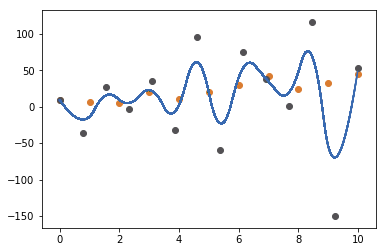

[   9.          -36.21201798   26.89116398   -3.5676898    34.84358456
  -31.35036473   95.92764651  -58.99793784   74.7452386    37.74557054
    1.23540959  116.20444225 -150.25295956   52.99534123]
[[   0.            9.        ]
 [   0.76923077  -36.21201798]
 [   1.53846154   26.89116398]
 [   2.30769231   -3.5676898 ]
 [   3.07692308   34.84358456]
 [   3.84615385  -31.35036473]
 [   4.61538462   95.92764651]
 [   5.38461538  -58.99793784]
 [   6.15384615   74.7452386 ]
 [   6.92307692   37.74557054]
 [   7.69230769    1.23540959]
 [   8.46153846  116.20444225]
 [   9.23076923 -150.25295956]
 [  10.           52.99534123]]


In [81]:
x_min = data[0][0]
x_max = data[-1][0]
x_range = x_max - x_min
y_values = betaHat[:, 0]
step = x_range / (len(y_values)-1)
cur = 0.0
x_values = []
for x in range(len(y_values)):
    x_values.append(cur)
    cur += step
control_points = np.array(list(zip(x_values, y_values)))
xx = np.linspace(0.0, 1.0, 100)
knots = uniform_knots(len(control_points), order)
print(len(points), len(knots))
curve = BSplineCurve(order, knots, control_points)
points = []
for u in range(0, 1000, 1):
    points.append(curve(u/1000.0))
    plt.plot([p[0] for p in points], [p[1] for p in points], color=colors.line["blue"])
plt.scatter(data[:, 0], data[:, 1], color=colors.line["orange"])
plt.scatter([p[0] for p in control_points], [p[1] for p in control_points], color=colors.line["grey"])
plt.show()
print(betaHat[:, 0])
print(control_points)